In [ ]:
!wget https://64.media.tumblr.com/5e0c6acb25df56613907574c0cd244e4/tumblr_mhwsoaQpXT1rttifoo1_1280.jpg

--2024-10-27 05:00:50--  https://64.media.tumblr.com/5e0c6acb25df56613907574c0cd244e4/tumblr_mhwsoaQpXT1rttifoo1_1280.jpg
Resolving 64.media.tumblr.com (64.media.tumblr.com)... 192.0.77.3
Connecting to 64.media.tumblr.com (64.media.tumblr.com)|192.0.77.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 443180 (433K) [image/jpeg]
Saving to: ‘tumblr_mhwsoaQpXT1rttifoo1_1280.jpg’

tumblr_mhwsoaQpXT1r 100%[===================>] 432.79K  --.-KB/s    in 0.007s  

2024-10-27 05:00:50 (60.3 MB/s) - ‘tumblr_mhwsoaQpXT1rttifoo1_1280.jpg’ saved [443180/443180]



# global memory versions

Time taken: 4.22052264213562 seconds


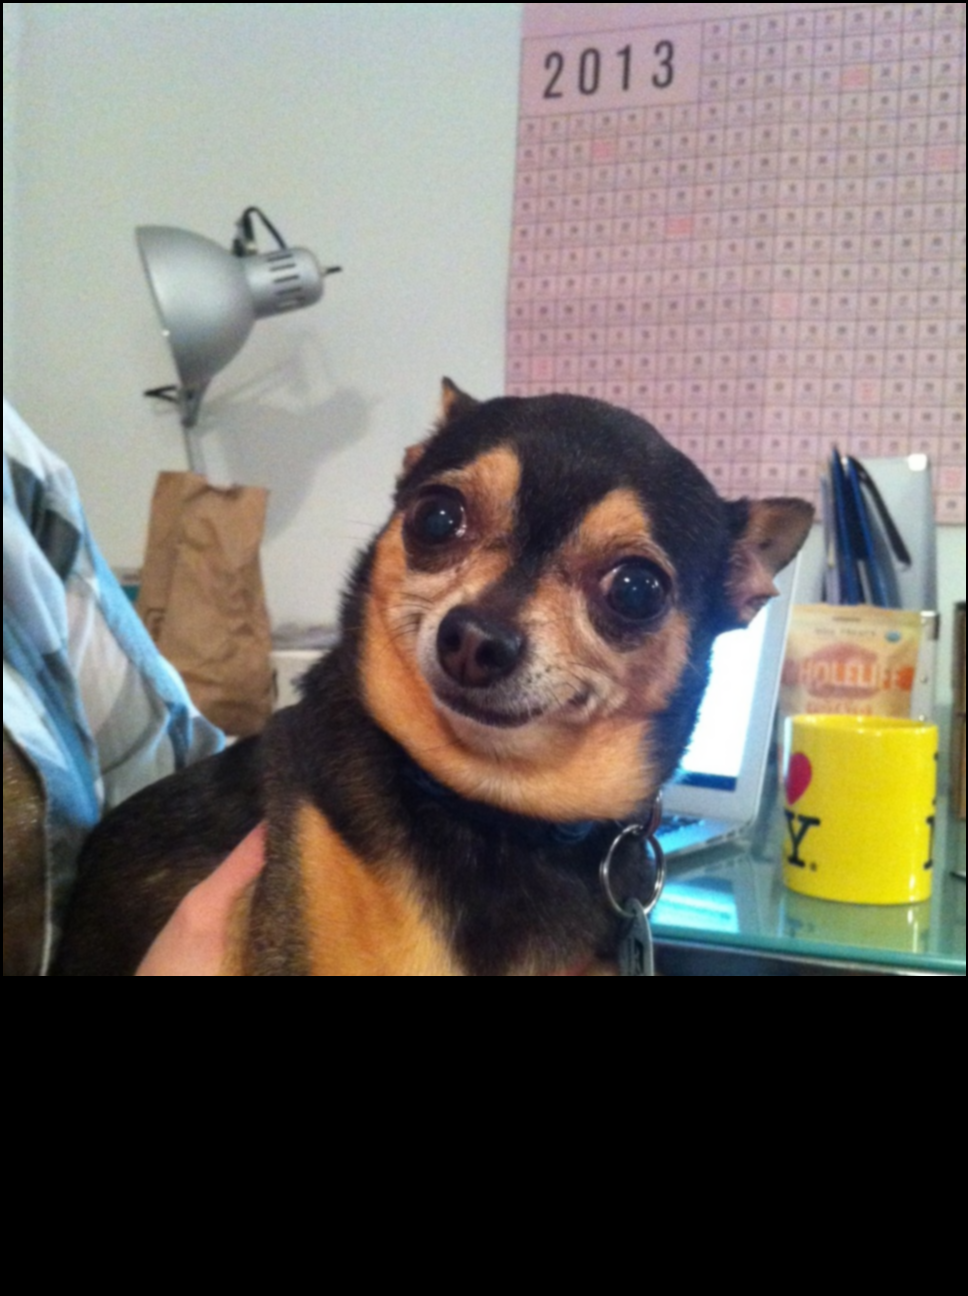

In [ ]:
from PIL import Image
import time
from numba import cuda
from math import exp, pi
from IPython.display import display

# Gaussian blur kernel on the GPU
@cuda.jit
def gaussian_blur_gpu(rgb_array, blurred_array, kernel, kernel_size):
    x, y = cuda.grid(2)
    half_k = kernel_size // 2
    if half_k - 1 < x < rgb_array.shape[0] - half_k + 1 and half_k - 1 < y < rgb_array.shape[1] - half_k + 1:

        r_sum = 0.0
        g_sum = 0.0
        b_sum = 0.0
        norm_factor = 0.0

        # Convolve the kernel with the image
        for i in range(-half_k, half_k + 1):
            for j in range(-half_k, half_k + 1):
                x_idx = x + i
                y_idx = y + j

                r = rgb_array[x_idx][y_idx][0]
                g = rgb_array[x_idx][y_idx][1]
                b = rgb_array[x_idx][y_idx][2]

                weight = kernel[half_k + i][half_k + j]
                r_sum += r * weight
                g_sum += g * weight
                b_sum += b * weight
                norm_factor += weight

        blurred_array[x][y][0] = r_sum / norm_factor
        blurred_array[x][y][1] = g_sum / norm_factor
        blurred_array[x][y][2] = b_sum / norm_factor


# Start the timer
start_time = time.time()

# Load the image and convert to a list
img = Image.open('/content/tumblr_mhwsoaQpXT1rttifoo1_1280.jpg')
rgb_array = list(img.getdata()) # len 1296*968 x 3

width, height = img.size
rgb_array = [list(rgb_array[i * width:(i + 1) * width]) for i in range(height)] # len 1296 x 968 x 3

# Create an empty array for the blurred image
blurred_array = [[[0.0 for _ in range(3)] for _ in range(width)] for _ in range(height)]


# Define the kernel as a 2D list
kernel = [
    [0, 0, 1, 2, 1, 0, 0],
    [0, 3, 13, 22, 13, 3, 0],
    [1, 13, 59, 97, 59, 13, 1],
    [2, 22, 97, 159, 97, 22, 2],
    [1, 13, 59, 97, 59, 13, 1],
    [0, 3, 13, 22, 13, 3, 0],
    [0, 0, 1, 2, 1, 0, 0]
]



# Define the block and grid size for GPU execution
threads_per_block = (16, 16)  # 16x16 block size
blocks_per_grid_x = (width + threads_per_block[0] - 1) // threads_per_block[0]
blocks_per_grid_y = (height + threads_per_block[1] - 1) // threads_per_block[1]
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

# # Copy data to the GPU

# print(rgb_array)
rgb_array_device = cuda.to_device(rgb_array)
blurred_array_device = cuda.to_device(blurred_array) #alloc
kernel_device = cuda.to_device(kernel)

# Run the kernel on the GPU
gaussian_blur_gpu[blocks_per_grid, threads_per_block](rgb_array_device, blurred_array_device, kernel_device, kernel_size)

#Copy the result back to the host
blurred_array = blurred_array_device.copy_to_host().tolist()


# End the timer
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")


import numpy as np
blurred_array_np = np.array(blurred_array, dtype=np.uint8)

# Convert the NumPy array to a PIL image
image = Image.fromarray(blurred_array_np)

# Display the image
display(image)

In [ ]:
print(len(blurred_array))
print(len(blurred_array[0]))
print(len(blurred_array[0][0]))

1296
968
3


# with share memory

Time taken: 0.8310866355895996 seconds


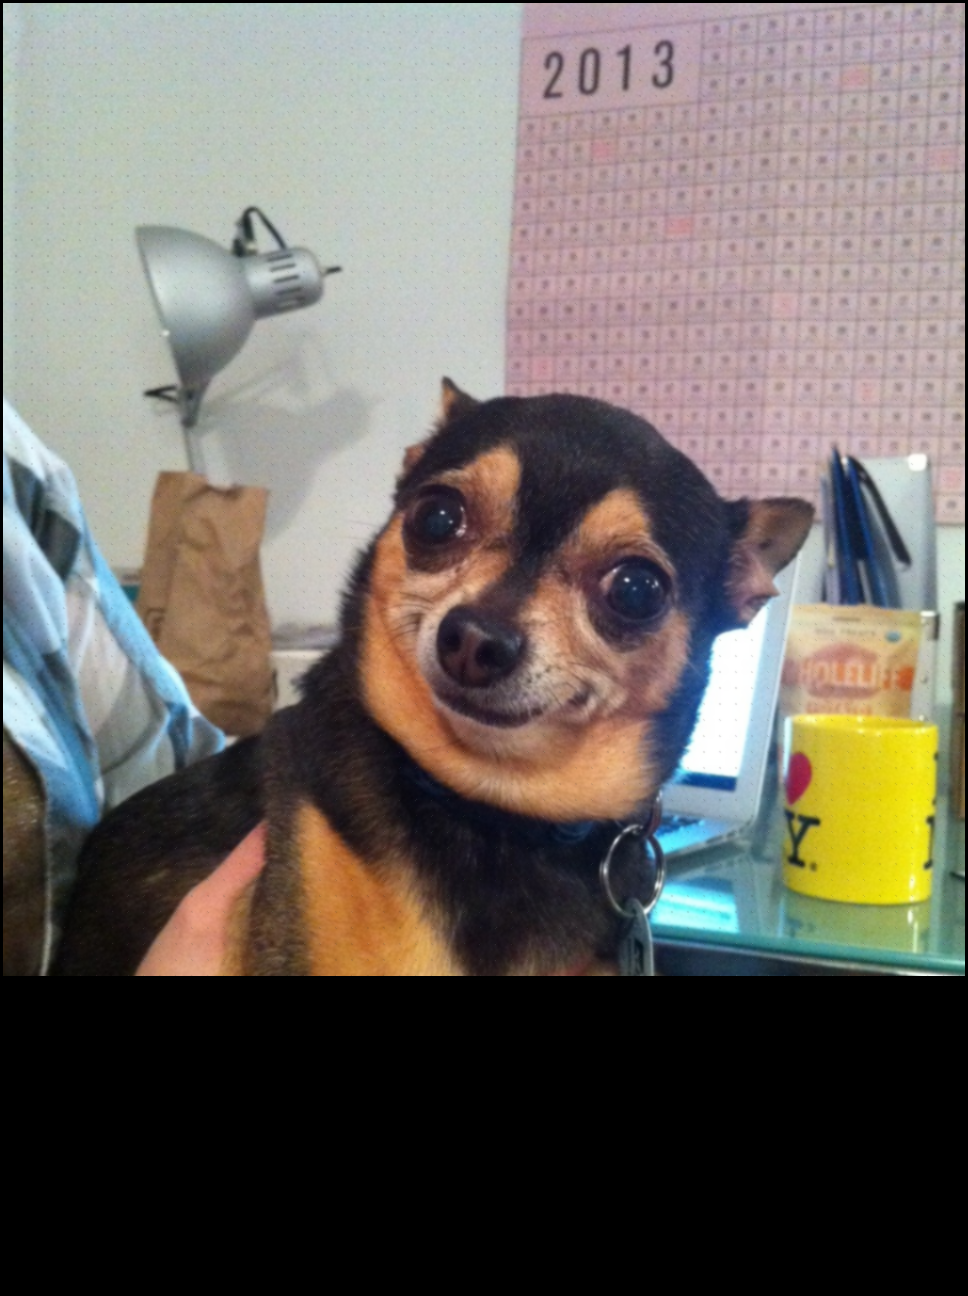

In [ ]:
from PIL import Image
import time
from numba import cuda
import numpy as np
from IPython.display import display

# Gaussian blur kernel on the GPU using shared memory
@cuda.jit
def gaussian_blur_gpu_shared(rgb_array, blurred_array, kernel, kernel_size):
    # Define the shared memory
    shared_mem = cuda.shared.array(shape=(32, 32, 3), dtype=np.float32)

    # Calculate the thread indices
    x, y = cuda.grid(2)
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y

    half_k = kernel_size // 2

    # Load data into shared memory
    for c in range(3):  # Iterate over color channels (R, G, B)
        if (x < rgb_array.shape[0]) and (y < rgb_array.shape[1]):
            shared_mem[tx + half_k, ty + half_k, c] = rgb_array[x, y, c]

            # Load halo elements (boundary elements)
            if tx < half_k:
                if x >= half_k:
                    shared_mem[tx, ty + half_k, c] = rgb_array[x - half_k, y, c]
                if x + cuda.blockDim.x < rgb_array.shape[0]:
                    shared_mem[tx + cuda.blockDim.x + half_k, ty + half_k, c] = rgb_array[x + cuda.blockDim.x, y, c]
            if ty < half_k:
                if y >= half_k:
                    shared_mem[tx + half_k, ty, c] = rgb_array[x, y - half_k, c]
                if y + cuda.blockDim.y < rgb_array.shape[1]:
                    shared_mem[tx + half_k, ty + cuda.blockDim.y + half_k, c] = rgb_array[x, y + cuda.blockDim.y, c]

    # Synchronize threads to ensure shared memory is fully loaded
    cuda.syncthreads()

    # Perform convolution only if the thread is inside the valid region
    if half_k <= x < rgb_array.shape[0] - half_k and half_k <= y < rgb_array.shape[1] - half_k:
        r_sum = 0.0
        g_sum = 0.0
        b_sum = 0.0
        norm_factor = 0.0

        # Apply the Gaussian blur filter using shared memory
        for i in range(-half_k, half_k + 1):
            for j in range(-half_k, half_k + 1):
                weight = kernel[half_k + i, half_k + j]
                r_sum += shared_mem[tx + i + half_k, ty + j + half_k, 0] * weight
                g_sum += shared_mem[tx + i + half_k, ty + j + half_k, 1] * weight
                b_sum += shared_mem[tx + i + half_k, ty + j + half_k, 2] * weight
                norm_factor += weight

        # Store the results in the blurred array
        blurred_array[x, y, 0] = r_sum / norm_factor
        blurred_array[x, y, 1] = g_sum / norm_factor
        blurred_array[x, y, 2] = b_sum / norm_factor

# Start the timer
start_time = time.time()

# Load the image and convert to a NumPy array
img = Image.open('/content/tumblr_mhwsoaQpXT1rttifoo1_1280.jpg')
rgb_array = np.array(img, dtype=np.float32)

height, width, _ = rgb_array.shape

# Create an empty array for the blurred image
blurred_array = np.zeros_like(rgb_array, dtype=np.float32)

# Define the Gaussian kernel
kernel = np.array([
    [0, 0, 1, 2, 1, 0, 0],
    [0, 3, 13, 22, 13, 3, 0],
    [1, 13, 59, 97, 59, 13, 1],
    [2, 22, 97, 159, 97, 22, 2],
    [1, 13, 59, 97, 59, 13, 1],
    [0, 3, 13, 22, 13, 3, 0],
    [0, 0, 1, 2, 1, 0, 0]
], dtype=np.float32)
kernel_size = kernel.shape[0]

# Define block and grid size
threads_per_block = (16, 16)
blocks_per_grid_x = (width + threads_per_block[0] - 1) // threads_per_block[0]
blocks_per_grid_y = (height + threads_per_block[1] - 1) // threads_per_block[1]
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

# Copy data to the GPU
rgb_array_device = cuda.to_device(rgb_array)
blurred_array_device = cuda.to_device(blurred_array)
kernel_device = cuda.to_device(kernel)

# Run the Gaussian blur kernel
gaussian_blur_gpu_shared[blocks_per_grid, threads_per_block](rgb_array_device, blurred_array_device, kernel_device, kernel_size)

# Copy the blurred image back to the host
blurred_array = blurred_array_device.copy_to_host()

# End the timer
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

# Convert the blurred array to a uint8 NumPy array and then to an image
blurred_array_np = np.clip(blurred_array, 0, 255).astype(np.uint8)
image = Image.fromarray(blurred_array_np)

# Display the resulting image
display(image)
